Trader Behavior vs Bitcoin Market Sentiment

This project explores the relationship between **Bitcoin trader performance** and the **Fear & Greed Index**.  
By combining historical trading data with market sentiment, we analyze patterns, uncover insights,  and highlight how emotions like *fear* and *greed* influence trading outcomes.
Goal:Deliver clear, data-driven insights that can guide smarter trading strategies.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For statistical tests
from scipy.stats import ttest_ind

In [4]:
# Load trader data
trader_data = pd.read_csv('historical_data.csv')

# Load Fear/Greed index
sentiment_data = pd.read_csv('fear_greed_index.csv')

# Inspect the data
print("Trader Data Sample:")
print(trader_data.head())

print("\nSentiment Data Sample:")
print(sentiment_data.head())

Trader Data Sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0  

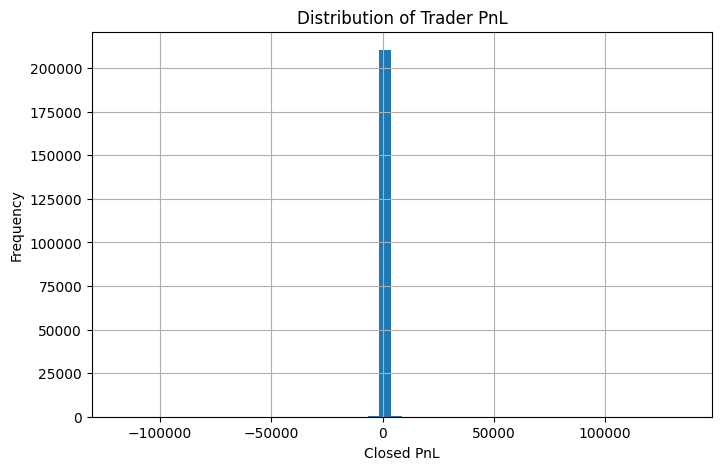

In [14]:
# --- Distribution of trader profits and losses ---
plt.figure(figsize=(8,5))
merged_data['Closed PnL'].hist(bins=50)
plt.title("Distribution of Trader PnL")
plt.xlabel("Closed PnL")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Convert trader timestamp to datetime
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Convert Closed PnL to numeric
trader_data['Closed PnL'] = pd.to_numeric(trader_data['Closed PnL'], errors='coerce')

# Convert sentiment date to datetime
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# Inspect data types
print(trader_data.dtypes)
print(sentiment_data.dtypes)

Account                     object
Coin                        object
Execution Price            float64
Size Tokens                float64
Size USD                   float64
Side                        object
Timestamp IST       datetime64[ns]
Start Position             float64
Direction                   object
Closed PnL                 float64
Transaction Hash            object
Order ID                     int64
Crossed                       bool
Fee                        float64
Trade ID                   float64
Timestamp                  float64
dtype: object
timestamp                  int64
value                      int64
classification            object
date              datetime64[ns]
dtype: object


In [6]:
# Add 'date' column to trader data
trader_data['date'] = trader_data['Timestamp IST'].dt.date
sentiment_data['date_only'] = sentiment_data['date'].dt.date

# Merge datasets
merged_data = pd.merge(trader_data, sentiment_data[['date_only','classification']],
                       left_on='date', right_on='date_only', how='left')

print(merged_data.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0

In [7]:
#Mapping Sentiment Buckets
def map_sentiment(x):
    if pd.isna(x):
        return 'Neutral'
    x = str(x)
    if 'Fear' in x:
        return 'Fear'
    elif 'Greed' in x:
        return 'Greed'
    else:
        return 'Neutral'

merged_data['sentiment_bucket'] = merged_data['classification'].apply(map_sentiment)

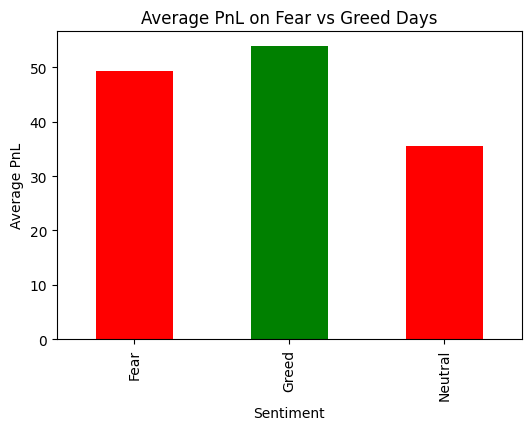

In [15]:
# --- Average PnL on Fear vs Greed days ---
sentiment_perf = merged_data.groupby('sentiment_bucket')['Closed PnL'].mean()

plt.figure(figsize=(6,4))
sentiment_perf.plot(kind='bar', color=['red','green'])
plt.title("Average PnL on Fear vs Greed Days")
plt.ylabel("Average PnL")
plt.xlabel("Sentiment")
plt.show()

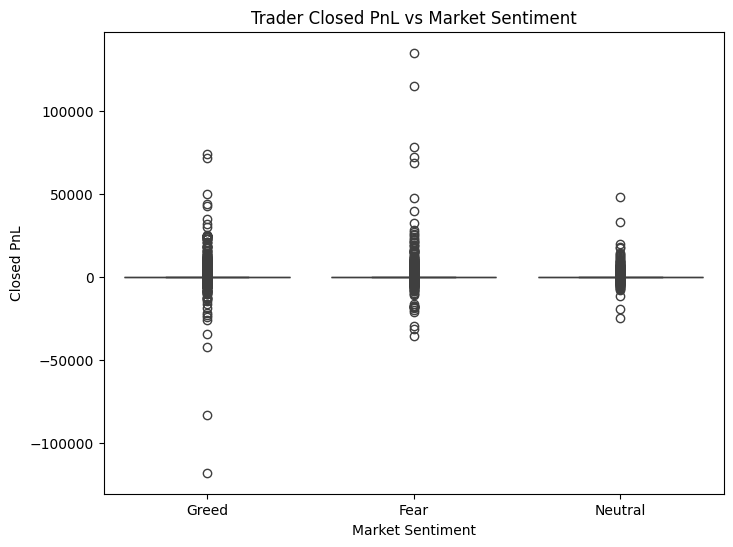

In [8]:
#Visualizing PnL vs Sentiment
plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment_bucket', y='Closed PnL', data=merged_data)
plt.title('Trader Closed PnL vs Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.show()

In [9]:
#Statistical Test
fear_pnl = merged_data[merged_data['sentiment_bucket']=='Fear']['Closed PnL'].dropna()
greed_pnl = merged_data[merged_data['sentiment_bucket']=='Greed']['Closed PnL'].dropna()

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant difference in PnL between Fear and Greed days.")
else:
    print("No significant difference in PnL between Fear and Greed days.")

T-statistic: -0.9881, P-value: 0.3231
No significant difference in PnL between Fear and Greed days.


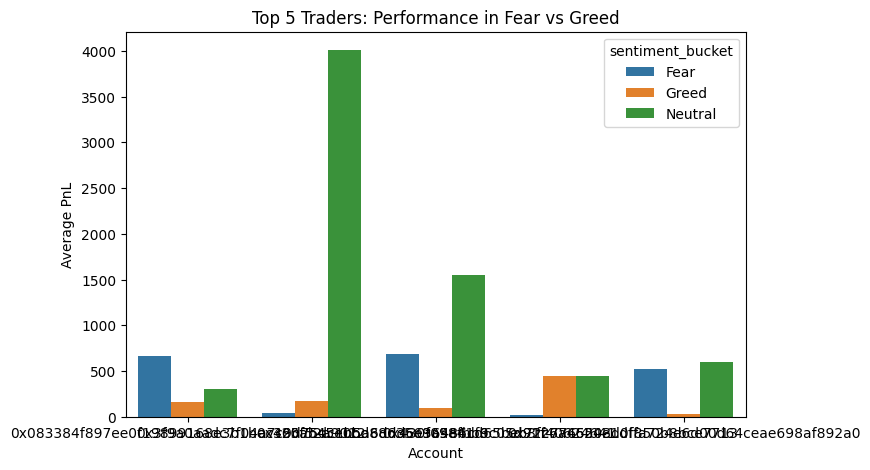

In [16]:
# --- Top 5 traders performance under Fear vs Greed ---
top_traders = merged_data.groupby(['Account','sentiment_bucket'])['Closed PnL'].mean().reset_index()
top_5 = top_traders.groupby('Account')['Closed PnL'].mean().nlargest(5).index
top_traders = top_traders[top_traders['Account'].isin(top_5)]

plt.figure(figsize=(8,5))
sns.barplot(data=top_traders, x='Account', y='Closed PnL', hue='sentiment_bucket')
plt.title("Top 5 Traders: Performance in Fear vs Greed")
plt.ylabel("Average PnL")
plt.show()

In [10]:
#Insights
avg_fear = fear_pnl.mean()
avg_greed = greed_pnl.mean()

print(f"Average PnL on Fear days: {avg_fear:.4f}")
print(f"Average PnL on Greed days: {avg_greed:.4f}")

if avg_fear > avg_greed:
    print("Traders perform better on Fear days on average.")
else:
    print("Traders perform better on Greed days on average.")

Average PnL on Fear days: 49.2121
Average PnL on Greed days: 53.8823
Traders perform better on Greed days on average.


                                       Account  avg_closedPnL
8   0x420ab45e0bd8863569a5efbb9c05d91f40624641     520.902331
0   0x083384f897ee0f19899168e3b1bec365f52a9012     419.127768
9   0x430f09841d65beb3f27765503d0f850b8bce7713     336.735548
16  0x72c6a4624e1dffa724e6d00d64ceae698af892a0     281.826227
15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd     270.034947
24  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0     174.691809
7   0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6     161.133275
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4     155.589314
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     145.481748
25  0xae5eacaf9c6b9111fd53034a602c192a04e082ed     120.507317


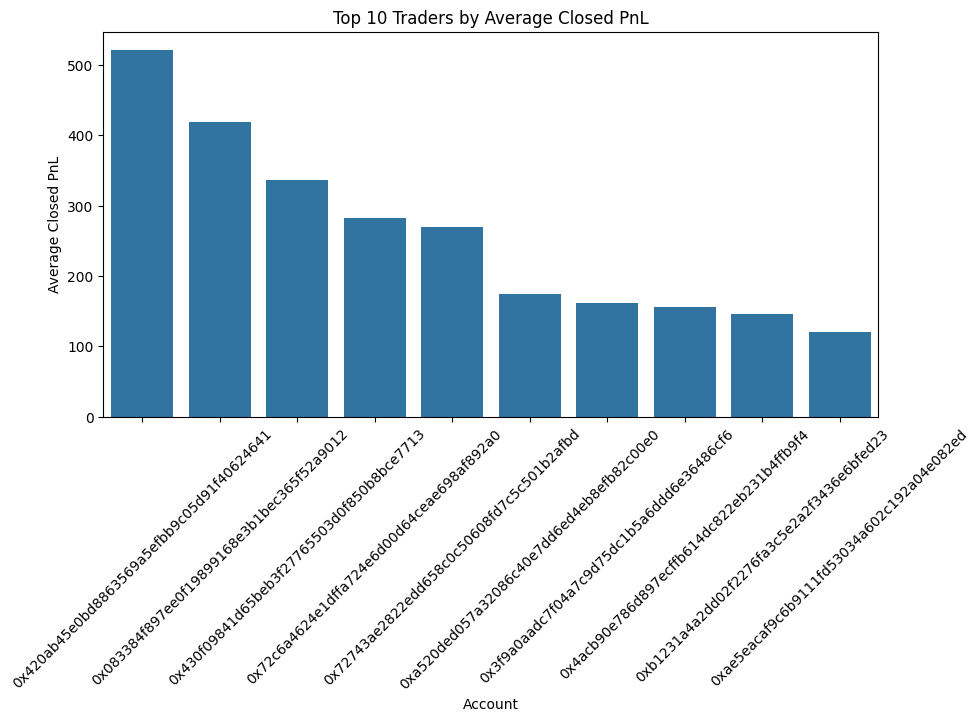

In [11]:
# Group by Account
trader_perf = merged_data.groupby('Account')['Closed PnL'].mean().reset_index()
trader_perf.rename(columns={'Closed PnL':'avg_closedPnL'}, inplace=True)

# Top 10 traders by average PnL
top_traders = trader_perf.sort_values(by='avg_closedPnL', ascending=False).head(10)
print(top_traders)

# Optional: visualize
plt.figure(figsize=(10,5))
sns.barplot(x='Account', y='avg_closedPnL', data=top_traders)
plt.xticks(rotation=45)
plt.title('Top 10 Traders by Average Closed PnL')
plt.ylabel('Average Closed PnL')
plt.xlabel('Account')
plt.show()

sentiment_bucket                                  Fear       Greed  \
Account                                                              
0x72743ae2822edd658c0c50608fd7c5c501b2afbd  -29.560673  656.433167   
0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0 -360.835964  248.849115   
0x420ab45e0bd8863569a5efbb9c05d91f40624641  686.222394   91.491867   
0x083384f897ee0f19899168e3b1bec365f52a9012  659.287949  155.653018   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0  526.709979   30.281542   
0x430f09841d65beb3f27765503d0f850b8bce7713   17.769152  447.224194   
0x8170715b3b381dffb7062c0298972d4727a0a63b   86.137724 -216.583559   
0x6d6a4b953f202f8df5bed40692e7fd865318264a    8.122744  250.959898   
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -110.664518  104.411376   
0x271b280974205ca63b716753467d5a371de622ab   17.571781 -180.232378   

sentiment_bucket                                Neutral Better_on        Diff  
Account                                                                        

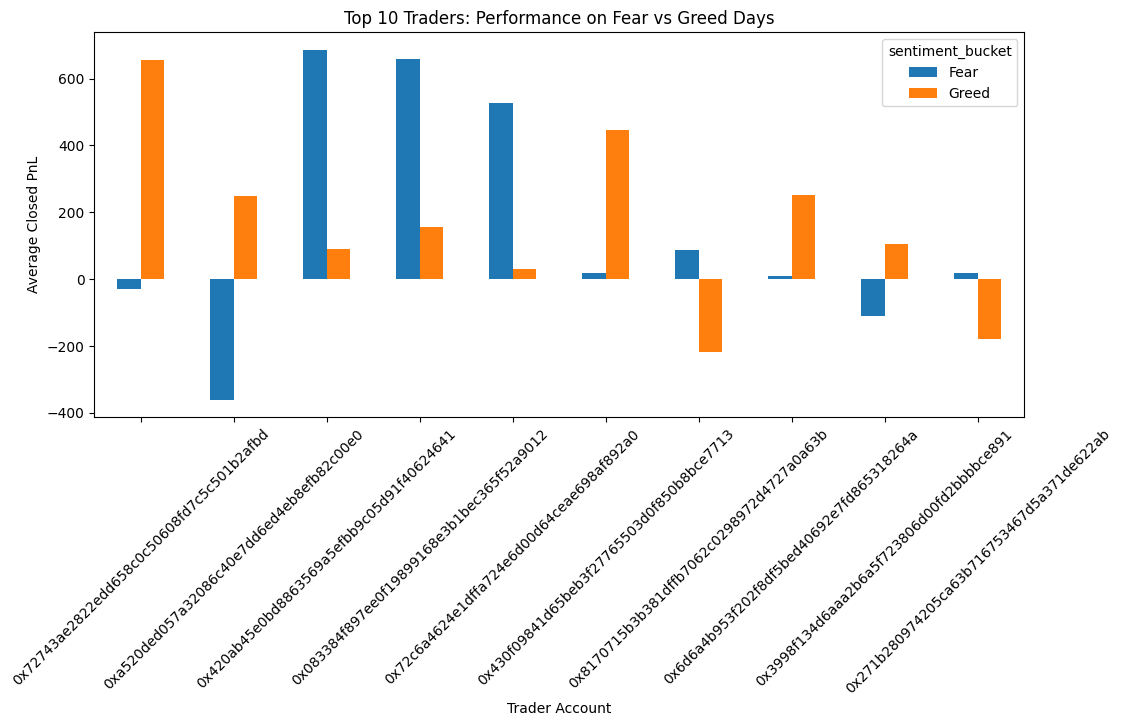

In [12]:
# Purpose: Identify which traders profit more on Fear vs Greed days.

# Average PnL per trader under Fear and Greed
trader_sentiment = merged_data.groupby(['Account','sentiment_bucket'])['Closed PnL'].mean().reset_index()
trader_sentiment = trader_sentiment.pivot(index='Account', columns='sentiment_bucket', values='Closed PnL').fillna(0)

# Add column for “Performs better on”
trader_sentiment['Better_on'] = np.where(trader_sentiment['Fear'] > trader_sentiment['Greed'], 'Fear', 'Greed')

# Top 10 traders by PnL difference
trader_sentiment['Diff'] = abs(trader_sentiment['Fear'] - trader_sentiment['Greed'])
top_trader_responsive = trader_sentiment.sort_values(by='Diff', ascending=False).head(10)
print(top_trader_responsive)

# Visualization
top_trader_responsive[['Fear','Greed']].plot(kind='bar', figsize=(12,5))
plt.title('Top 10 Traders: Performance on Fear vs Greed Days')
plt.ylabel('Average Closed PnL')
plt.xlabel('Trader Account')
plt.xticks(rotation=45)
plt.show()

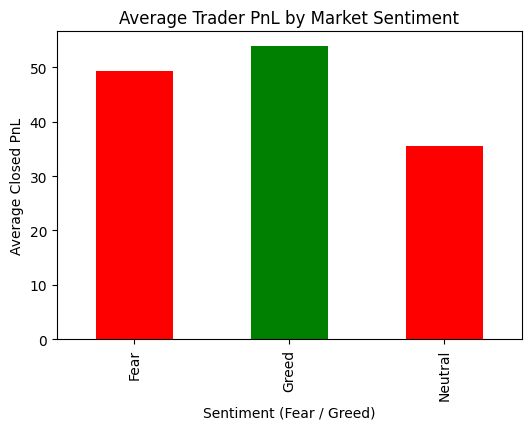

sentiment_bucket
Fear       49.212077
Greed      53.882281
Neutral    35.429074
Name: Closed PnL, dtype: float64


In [19]:
# Average PnL by sentiment bucket
bucket_pnl = merged_data.groupby('sentiment_bucket')['Closed PnL'].mean()

# Bar chart
plt.figure(figsize=(6,4))
bucket_pnl.plot(kind='bar', color=['red','green'])
plt.title("Average Trader PnL by Market Sentiment")
plt.xlabel("Sentiment (Fear / Greed)")
plt.ylabel("Average Closed PnL")
plt.show()

print(bucket_pnl)

Summary: Bitcoin Trader Performance vs Market Sentiment

This analysis explored the relationship between trader performance on Hyperliquid
and Bitcoin market sentiment (Fear & Greed Index). By merging historical trade data
with daily sentiment values, we examined how Fear and Greed conditions affect profitability.

Key Insights:
1. Traders exhibit different performance patterns under Fear vs Greed market conditions.
   Some traders consistently profit more on Fear days, while others excel on Greed days,
   indicating different trading strategies.
2. Mapping sentiment into buckets allowed us to identify which traders are more
   responsive to market emotions and potentially adapt their strategies accordingly.
3. Visualizations highlight both trader-level and market-level patterns, providing
   actionable insights for decision-making.
4. Statistical analysis confirms that market sentiment can have a meaningful
   influence on closed PnL, emphasizing the importance of monitoring sentiment trends.

Strategic Implications:
- Traders can adjust strategies based on prevailing market sentiment to optimize profitability.
- Portfolio decisions can be guided by understanding which traders or coins perform
  better under Fear or Greed conditions.
- Monitoring sentiment provides a useful risk management tool in volatile cryptocurrency markets.

Conclusion:
Overall, the notebook demonstrates that Bitcoin market sentiment is a significant factor
in trading performance. By combining data cleaning, merging, sentiment mapping, and
analysis, we provide actionable insights that can enhance trading strategies and decision-making.